In [1]:
import sys, os, h5py, warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal, ndimage, stats, interpolate, integrate

import py21cmfast as p21c
from py21cmfast import plotting
from py21cmfast import cache_tools
cache_tools.clear_cache()

sys.path.append('../XRay_Development/')
from field_smoother import WindowedData

# We change the default level of the logger so that
# we can see what's happening with caching.
import logging, sys, os
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)
%matplotlib inline

from astropy import cosmology, constants, units
from astropy.cosmology import Planck18 as cosmo
from astropy import constants, units

/global/homes/f/fosterjw/.conda/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  "Your configuration file is out of date. Updating..."
/global/homes/f/fosterjw/.conda/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


# Configure the Run

### Basic 21cmFAST Config and Initial Conditions

In [2]:
p21c.global_params.ZPRIME_STEP_FACTOR = 1.01

In [3]:
# This method gets the evaluation redshifts from 21cmFAST
def get_z_arr(z_start=None, z_end=5):
    
    if z_start is None:
        z_start = p21c.global_params.Z_HEAT_MAX
    z_arr = [z_end]
    while np.max(z_arr) < z_start:
        z_prev = (1 + np.max(z_arr)) * p21c.global_params.ZPRIME_STEP_FACTOR - 1
        z_arr.append(z_prev)
    return np.array(z_arr[::-1][1:])

/global/homes/f/fosterjw/.conda/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/inputs.py:488: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  "The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be "


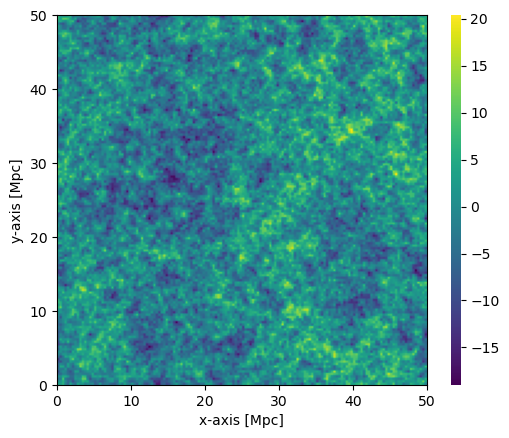

In [4]:
user_params = {"HII_DIM": 50, "BOX_LEN": 50.}
cosmo_params = dict(OMm=0.32, OMb=0.049, POWER_INDEX=0.96, SIGMA_8=0.83, hlittle=0.67)

initial_conditions = p21c.initial_conditions(
    user_params = user_params,
    cosmo_params = cosmo_params,
    random_seed=54321
)
plotting.coeval_sliceplot(initial_conditions, "hires_density");

### Dark History Config and Field Smoother

In [5]:
# X-Ray Spectrum Bins
ex_lo = .1 # keV
ex_hi = 10 # keV
n_xbins = 10

x_bin_edges = np.geomspace(ex_lo, ex_hi, n_xbins+1)
x_bin_centers = (x_bin_edges[1:] + x_bin_edges[:-1]) / 2

# Global Bath Bins
eb_hi = 100e6 # keV
n_bbins = 100

g_bin_edges = np.geomspace(ex_hi, eb_hi, n_bbins+1)
b_bin_centers = (g_bin_edges[1:] + g_bin_edges[:-1]) / 2

In [6]:
field_path = './Smoothed_Fields.h5'
if os.path.isfile(field_path):
    os.remove(field_path)

dx = initial_conditions.user_params.BOX_LEN / initial_conditions.user_params.HII_DIM
N = initial_conditions.user_params.HII_DIM
windowed_data = WindowedData(field_path, cosmo, N, dx, n_xbins)

# Take the first 21cmFAST Step

Here we take the first 21cm fast step so that we at a redshift later that the `Z_HEAT_MAX` redshift set in 21cmFAST

The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Evolving to the start at: 34.97481185213704
Just Before Box Evaluation


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


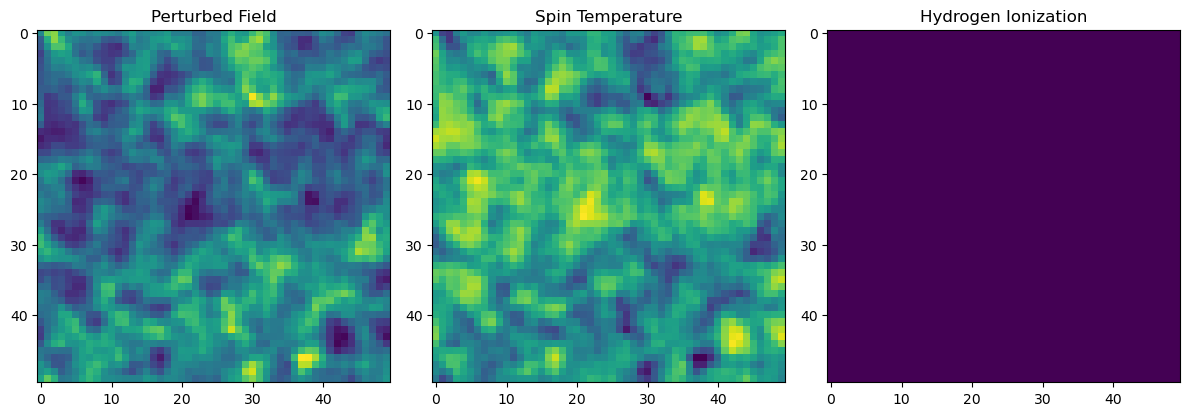

In [7]:
print('Evolving to the start at:', get_z_arr()[0])
perturbed_field = p21c.perturb_field(redshift = get_z_arr()[0], init_boxes = initial_conditions)
spin_temp = p21c.spin_temperature(perturbed_field = perturbed_field)
ionized_field = p21c.ionize_box(spin_temp = spin_temp)
brightness_temp = p21c.brightness_temperature(spin_temp = spin_temp, ionized_box=ionized_field, perturbed_field=perturbed_field)

fig, axs = plt.subplots(ncols = 3, figsize = (12, 4))

axs[0].imshow(perturbed_field.density[0])
axs[1].imshow(spin_temp.Ts_box[0])
axs[2].imshow(ionized_field.xH_box[0])

axs[0].set_title('Perturbed Field')
axs[1].set_title('Spin Temperature')
axs[2].set_title('Hydrogen Ionization')

plt.tight_layout()

### Synchronize the 21cmFAST state with the Dark History State

In [8]:
# Replace these with their true values from Dark History
dh_xe_global = np.mean(spin_temp.x_e_box)
dh_tk_global = np.mean(spin_temp.Tk_box)

spin_temp.x_e_box +=  dh_xe_global - np.mean(spin_temp.x_e_box)
spin_temp.Tk_box +=  dh_tk_global - np.mean(spin_temp.Tk_box)

# Here after, the run 21cmFAST evolution with box injection

In [9]:
def OTS_Dummy(*kwargs):
    return np.ones((n_xbins)), np.ones((n_bbins)), 0, 0, 0

def Bath_Dummy(*kwargs):
    return np.ones((n_xbins)), np.ones((n_bbins)), 0, 0, 0

def XRay_Dummy(*kwargs):
    return np.ones((n_xbins)), np.ones((n_bbins)), 0, 0, 0

In [10]:
z_evals = get_z_arr(z_end = 5)[1:]
zindex = 0
print(z_evals[zindex])

34.618625596175285


### Generate 21cm Injection Boxes and Container Spectrum

In [11]:
input_heating = p21c.input_heating(redshift = z_evals[zindex], init_boxes = initial_conditions, write = False)
input_ionization = p21c.input_ionization(redshift = z_evals[zindex], init_boxes = initial_conditions, write = False)
input_jalpha = p21c.input_jalpha(redshift = z_evals[zindex], init_boxes = initial_conditions, write = False)

phot_xray_spec = np.zeros((n_xbins)) # The global average of the x-ray spectrum
phot_xray_box = np.zeros_like(spin_temp.Tk_box) # The local x-ray brightness parameter 
phot_bath_spec = np.zeros((n_bbins)) # The globally averaged homogeneous bath spectrum

### On the Spot and Global Bath Injection

In [12]:
# Looping over 
for i in range(initial_conditions.user_params.HII_DIM):
    for j in range(initial_conditions.user_params.HII_DIM):
        for k in range(initial_conditions.user_params.HII_DIM):
            
            #################################
            ###   On the Spot Injection   ###
            #################################
            
            pix_phot_xray_spec, pix_phot_bath_spec, pix_heating, pix_ionization, pix_jalpha = OTS_Dummy()
            
            # Add photon spectrum to global spectrum register
            phot_xray_spec += pix_phot_xray_spec
            phot_bath_spec += pix_phot_bath_spec

            # Record pixel quantities
            phot_xray_box[i, j, k] += np.sum(pix_phot_xray_spec)
            input_heating.input_heating[i, j, k] += pix_heating
            input_ionization.input_ionization[i, j, k] += pix_ionization
            input_jalpha.input_jalpha[i, j, k] += pix_jalpha
            
            ##################################
            ###   Global Bath  Injection   ###
            ##################################
            
            # Add photon spectrum to global spectrum register
            phot_xray_spec += pix_phot_xray_spec
            phot_bath_spec += pix_phot_bath_spec

            # Record pixel quantities
            phot_xray_box[i, j, k] += np.sum(pix_phot_xray_spec)
            input_heating.input_heating[i, j, k] += pix_heating
            input_ionization.input_ionization[i, j, k] += pix_ionization
            input_jalpha.input_jalpha[i, j, k] += pix_jalpha

### Propagating X-Ray Injection

In [13]:
test_index = 5

print('Injection at: ', z_evals[test_index])

for lookback_index in range(test_index):
    print(lookback_index, z_evals[test_index], z_evals[lookback_index],z_evals[lookback_index+1])
    print(windowed_data.get_smoothing_radii(z_evals[test_index], z_evals[lookback_index],z_evals[lookback_index+1]))
    break

Injection at:  32.88990009447226
0 32.88990009447226 34.618625596175285 34.26596593680721
(66.75152835333517, 53.534936345581634)


In [ ]:
cosmo.lookback_distance(10) cosmo.lookback_distance(11)

In [ ]:
for lookback_index in range(zindex):
    shell_smoothed, shell_spec = windowed_data.get_smoothed_shell(z_receiver, z_evals[lookback_index],  z_evals[lookback_index+1])
    
    for i in range(init_box.user_params.HII_DIM):
        for j in range(init_box.user_params.HII_DIM):
            for k in range(init_box.user_params.HII_DIM):
                pix_phot_xray_spec, pix_phot_bath_spec, pix_heating, pix_ionization, pix_jalpha = XRay_Dummy()

                # Add photon spectrum to global spectrum register
                phot_xray_spec += pix_phot_xray_spec
                phot_bath_spec += pix_phot_bath_spec

                # Record pixel quantities
                phot_xray_box[i, j, k] += np.sum(pix_phot_xray_spec)
                input_heating[i, j, k] += pix_heating
                input_ionization[i, j, k] += pix_ionization
                input_jalpha[i, j, k] += pix_jalpha

In [ ]:
# Average these back down to per-pixel quantities
phot_xray_spec /= initial_conditions.user_params.HII_DIM**3
phot_bath_spec /= initial_conditions.user_params.HII_DIM**3

# Normalize the xray brightness box
phot_xray_box /= np.mean(phot_xray_box)

### Save the Brightness Box and X-Ray Spectrum. Also set the global data.

In [ ]:
windowed_data.set_field(phot_xray_box, phot_xray_spec, z_evals[zindex])

windowed_data.global_Tk = np.append(windowed_data.global_Tk, np.mean(spin_temp.Tk_box))
windowed_data.global_x = np.append(windowed_data.global_x, np.mean(ionized_field.xH_box))

### Evolve with 21cmFAST + Injection

In [ ]:
perturbed_field = p21c.perturb_field(redshift = z_evals[zindex], init_boxes = initial_conditions)
spin_temp = p21c.spin_temperature(perturbed_field = perturbed_field, 
                                  input_heating_box = input_heating,
                                  input_ionization_box = input_ionization,
                                  input_jalpha_box = input_jalpha)
ionized_field = p21c.ionize_box(spin_temp = spin_temp)
brightness_temp = p21c.brightness_temperature(spin_temp = spin_temp, ionized_box=ionized_field, perturbed_field=perturbed_field)

In [ ]:
fig, axs = plt.subplots(ncols = 3, figsize = (12, 4))

axs[0].imshow(perturbed_field.density[0])
axs[1].imshow(spin_temp.Ts_box[0])
axs[2].imshow(ionized_field.xH_box[0])

axs[0].set_title('Perturbed Field')
axs[1].set_title('Spin Temperature')
axs[2].set_title('Hydrogen Ionization')

plt.tight_layout()